# Power measurements
- **Length in ns**. Converted to `SP_POINTS = length / 2.5ns`
- **Repetitions**. Split up into batches of `R_POINTS` (rounded to 1000 for optimised kernel performance) to the digitiser.

SP-DIGITISER:   🕱 Disconnected from digitiser.
POWER-PIPELINE: Building kernel with:
R_POINTS=64000
SP_POINTS=800
POWER-PIPELINE: Performing 16 runs (to acquire 1000000 averages)
🗑  Cleaning build objects
removed ‘./build/src/logging.o’
removed ‘./build/src/power_kernel_cpu.o’
removed ‘./build/src/power_kernel_gpu.o’
removed ‘./build/src/power_kernel_gpu_utils.o’
removed ‘./build/src/power_pipeline.o’
removed ‘./build/src/progress_bar.o’
removed ‘./build/src/sp_digitiser.o’
removed ‘./build/src/utils_gpu.o’
removed ‘./build/src/utils.o’
✅ [***] Done

Using flags: -D PYTHON=1 -D SP_POINTS=800 -D R_POINTS=64000 -D R_POINTS_PER_CHUNK=1000

🍕 [cpp] Building src/utils.cpp ⟶ build/./src/utils.o
🍕 [cpp] Building src/sp_digitiser.cpp ⟶ build/./src/sp_digitiser.o
🍕 [cpp] Building src/progress_bar.cpp ⟶ build/./src/progress_bar.o
🍕 [cpp] Building src/power_kernel_gpu_utils.cpp ⟶ build/./src/power_kernel_gpu_utils.o
🍕 [cpp] Building src/utils_gpu.cpp ⟶ build/./src/utils_gpu.o
🍕 [cpp] Building src

<IPython.core.display.Javascript object>


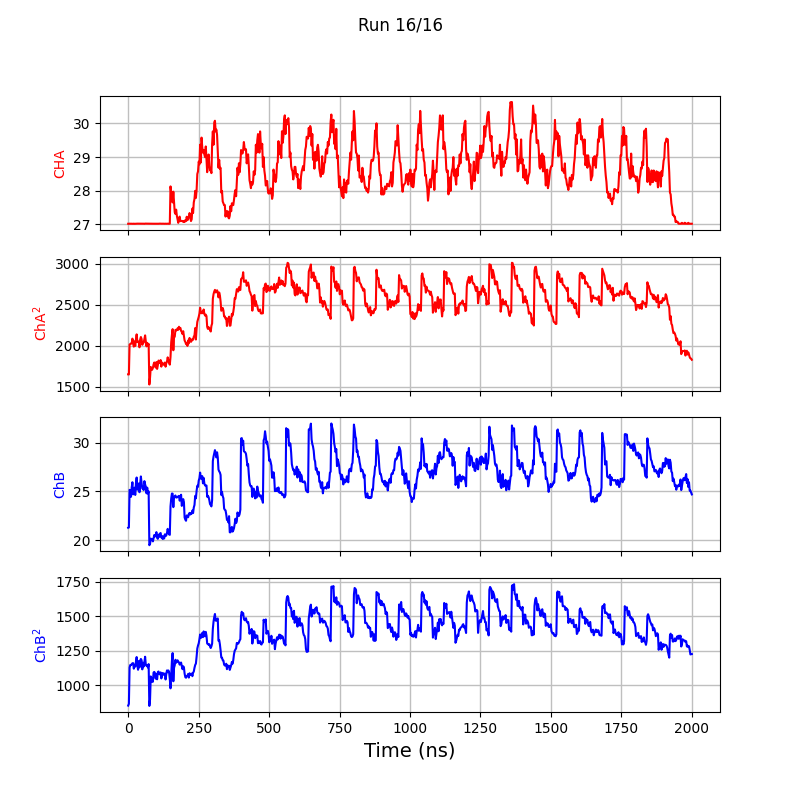

In [1]:
from python_app.sp_digitiser import SpDigitiser
from python_app.power_pipeline import PowerPipeline
%matplotlib notebook

TIME_IN_NS = 2000  # ns
AVERAGES = 1_000_000

pp = PowerPipeline(TIME_IN_NS, AVERAGES)

In [2]:
pp.execute_run(
    digitiser_parameters={
        "delay": 0,
        "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
        #     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
        "channelA_gain": 1,
        "channelB_gain": 1,
        "channelA_offset": 0,
        "channelB_offset": 0,
        "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE,
        "frequency_mode": SpDigitiser.HIGH_FREQUENCY_MODE
    },
    run_name="ttt"
)

SP-DIGITISER:   Trigger frequency: 340kHz
POWER-PIPELINE: Measurements started


0% [████████████████] 100% | ETA: 00:00:00

POWER-PIPELINE: Measurements done -> data dumped to ./dump/ttt.csv
SP-DIGITISER:   🕱 Disconnected from digitiser.



Total time elapsed: 00:00:23


In [ ]:
# Kernel must be relaunched if running in jupyter notebook in order to free the dll library being used
os._exit(0)